# Bayesian Optimizaiton of Delta-Tolling Hyperparameters

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from scipy import spatial

class PickupAndDeliveryGoalGenerator():
    def __init__(self, pickup_goal_loc_list, delivery_goal_loc_list,
                 pickup_distribution, delivery_distribution):
        self.pickup_goal_loc_list = pickup_goal_loc_list
        self.delivery_goal_loc_list = delivery_goal_loc_list
        
        # Make KD Tree for faster lookup
        self.pickup_tree = spatial.KDTree(pickup_goal_loc_list)
        self.delivery_tree = spatial.KDTree(delivery_goal_loc_list)
        
        self.pickup_distribution = pickup_distribution
        self.delivery_distribution = delivery_distribution
        
        # Currently unused but probably should do some sort of load balancing
        self.assigned_pickup_count = {}
        self.assigned_delivery_count = {}
        
        for key in self.pickup_goal_loc_list:
            self.assigned_pickup_count[key] = 0
        
        for key in self.delivery_goal_loc_list:
            self.assigned_delivery_count[key] = 0
        
        self.is_env_set = False
        self.env = None 
        
    def get_new_location(self, agent_id):
        if not self.is_env_set:
            raise ValueError("Env is not set yet.")
            
        agent_loc = self.env.agent_state[agent_id]
        goal_loc = self.env.agent_goal[agent_id]
        
        if agent_loc in self.assigned_pickup_count:
            self.assigned_pickup_count[agent_loc] -= 1
            next_sample = self.delivery_distribution.rvs()
            next_goal_loc = self.delivery_goal_loc_list[ \
                    self.delivery_tree.query(next_sample)[1]]
            self.assigned_delivery_count[next_goal_loc] += 1
            
        elif agent_loc in self.assigned_delivery_count:
            self.assigned_delivery_count[agent_loc] -= 1
            next_sample = self.pickup_distribution.rvs()
            next_goal_loc = self.pickup_goal_loc_list[self.pickup_tree.query(next_sample)[1]]
            self.assigned_pickup_count[next_goal_loc] += 1

        else:
            raise ValueError("Unable to find previous goal location.")
            
        return next_goal_loc
    
    def get_reset_location(self, agent_id):
        goal_loc = self.env.agent_goal[agent_id]
        if goal_loc in self.assigned_pickup_count:
            self.assigned_pickup_count[goal_loc] -= 1
        
        if goal_loc in self.assigned_delivery_count:
            self.assigned_delivery_count[goal_loc] -= 1
        
        next_sample = self.pickup_distribution.rvs()
        next_goal_loc = self.pickup_goal_loc_list[self.pickup_tree.query(next_sample)[1]]
        
        return next_goal_loc
        
    def set_env(self, env):
        self.env = env
        self.is_env_set = True


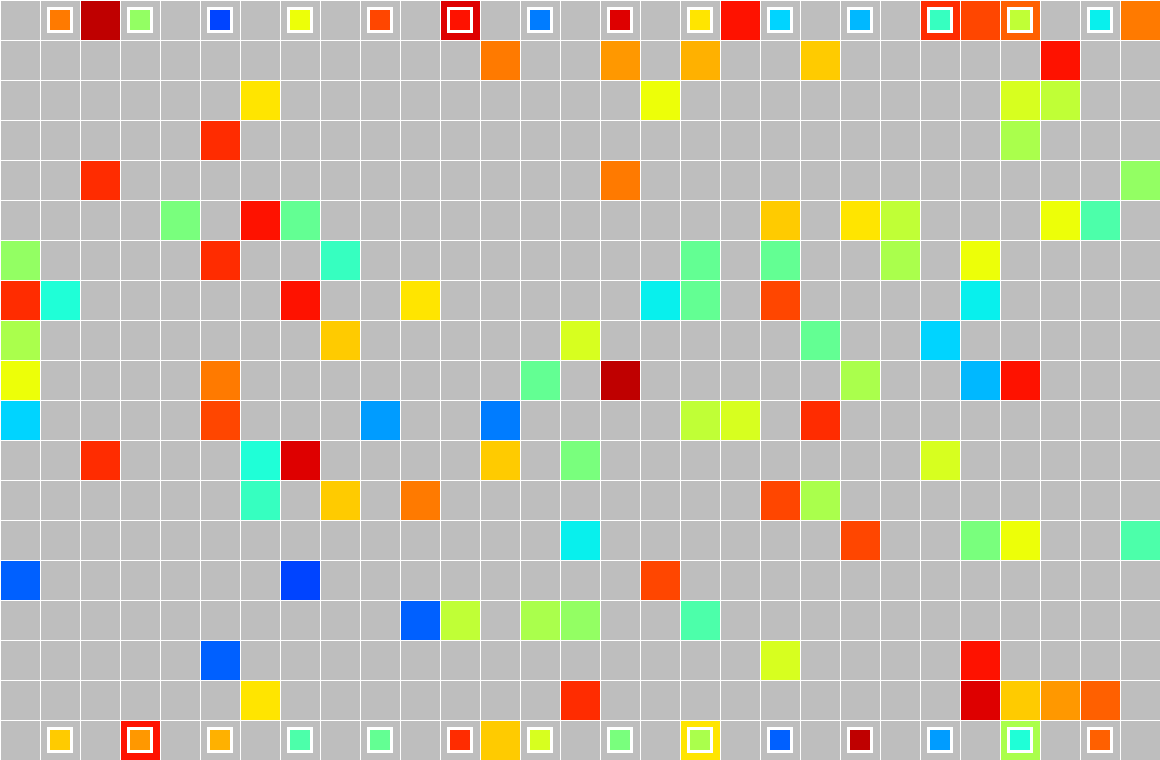

In [6]:
from warehouse_env.warehouse_env import WarehouseEnv
import numpy as np
from scipy.stats import multivariate_normal

def env_initialization(R, B):
    env_shape = (19, 29)
    num_agents = 100

    pd_world = np.zeros(env_shape)
    pd_agent= np.random.permutation([1] * num_agents + [0] * 
                    (env_shape[0] * env_shape[1] - num_agents)).reshape(env_shape)

    def indices_array_generic(m,n):
        r0 = np.arange(m) # Or r0,r1 = np.ogrid[:m,:n], out[:,:,0] = r0
        r1 = np.arange(n)
        out = np.empty((m,n,2),dtype=int)
        out[:,:,0] = r0[:,None]
        out[:,:,1] = r1
        return out

    world_indices = indices_array_generic(pd_world.shape[0], pd_world.shape[1])

    pickup_array1 = world_indices[-1, 1:-1:2, :]
    pickup_array1 = pickup_array1.flatten().reshape(pickup_array1.shape[0], 2)
    pickup_array2 = world_indices[0, 1:-1:2, :]
    pickup_array2 = pickup_array2.flatten().reshape(pickup_array2.shape[0], 2)
    pickup_array = np.concatenate((pickup_array1, pickup_array2)).tolist()

    delivery_array = world_indices[int(pd_world.shape[0]/2), 1:-2:2, :]
    delivery_array = delivery_array.flatten().reshape(delivery_array.shape[0], 2).tolist()

    center_mean = (int(pd_world.shape[0]/2), int(pd_world.shape[1]/2))
    center_cov = [[5, 0], [0, 100]]
    center_distribution = multivariate_normal(center_mean, center_cov)

    goal_generator = PickupAndDeliveryGoalGenerator(list(map(tuple, pickup_array)), 
                                                    list(map(tuple, delivery_array)),
                                                    center_distribution, center_distribution)

    pd_env = WarehouseEnv(agent_map=np.array(pd_agent), obstacle_map=np.array(pd_world), 
                            local_obseration_size=(9,7), render_as_observation=True,
                            goal_generator=goal_generator,
                            delta_tolling=True,
                            delta_tolling_r=0.5,
                            delta_tolling_b=4.0)
    return pd_env

env = env_initialization(0.5, 4.0)
env.render(zoom_size=40, local=False, draw_grid=True)

In [12]:
from od_mstar3 import cpp_mstar
import networkx as nx

def get_next_action(env, env_graph, coordinated_planner=False):
    if coordinated_planner:
        states = [(v[0], v[1]) for k, v in env.agent_state.items()]
        goals = [(v[0], v[1]) for k, v in env.agent_goal.items()]
        path = None
        start_x, start_y = None, None
        next_x, next_y = None, None

        try:
            path = cpp_mstar.find_path(env.obstacle_map, states, goals, 10, 5 * 60.0)

            start_x, start_y = env.agent_state[env.current_agent_id]
            next_x, next_y = path[1][env.current_agent_id]   
        except:
            coordinated_planner = False

    if not coordinated_planner:
        location = env.agent_state[env.current_agent_id]
        goal = env.agent_goal[env.current_agent_id]

        path = nx.astar_path(env_graph, (location[0], location[1]), 
                             (goal[0], goal[1]), weight='weight')

        action = None
        start_x, start_y = path[0]
        if len(path) == 1:
            return 4
        next_x, next_y = path[1]
        
    if (start_y + 1)  == next_y:
        return_val = 0
    elif (start_y - 1) == next_y:
        return_val = 2
    elif (start_x - 1) == next_x:
        return_val = 1
    elif (start_x + 1) == next_x:
        return_val = 3
    else:
        return_val = 4
    
    return return_val

In [13]:
def score_function(R, B):
    env = env_initialization(R, B)
    cum_reward = 0
    for t in range(5000):
        action = get_next_action(env, env.env_graph, coordinated_planner=False)
        _, reward, done, _ = env.step(action)
        cum_reward += reward
    return cum_reward

In [14]:
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

# Bounded region of parameter space
pbounds = {'R': (0.0001, 0.1), 'B': (2.0, 6.0)}

optimizer = BayesianOptimization(
    f=score_function,
    pbounds=pbounds,
    random_state=1,
)

In [21]:
logger = JSONLogger(path="/Users/pehuen/Documents/ucla/LEMUR/warehouse_rrl/bayes_opt_logs2.json")
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

optimizer.maximize(
    init_points=10,
    n_iter=120
)

KeyboardInterrupt: 

In [20]:
R_x = np.linspace(0.0001, 0.1, 500)
B_y = np.linspace(2.0, 6.0, 500)
X, Y = np.meshgrid(R_x, B_y)
xy = np.vstack([X.flatten(), Y.flatten()]).T
mu, sigma = optimizer._gp.predict([[0.001, 2.0]], return_std=True)
xy, mu, sigma, np.mean(mu), np.mean(sigma)

(array([[1.00000000e-04, 2.00000000e+00],
        [3.00200401e-04, 2.00000000e+00],
        [5.00400802e-04, 2.00000000e+00],
        ...,
        [9.95995992e-02, 6.00000000e+00],
        [9.97997996e-02, 6.00000000e+00],
        [1.00000000e-01, 6.00000000e+00]]),
 array([438.33333333]),
 array([83.76044392]),
 438.3333333333333,
 83.76044392081484)

In [26]:
R, B = 0.016532, 5.000604 # minimum
# R, B = 0.053493, 3.586970 # maximum
env = env_initialization(R, B)
frames = []
cum_reward = 0
for t in range(10000):
    frames.append(env.render(zoom_size=40, agent_id=None, draw_grid=True, local=False))
    action = get_next_action(env, env.env_graph, coordinated_planner=False)
    _, reward, done, _ = env.step(action)
    cum_reward += reward
    
frames[0].save('gif/bo_astar_dt=on_R={}_B={}.gif'.format(R, B),
               save_all=True, append_images=frames[1::env.num_agents], 
               optimize=False, duration=5, loop=0)


In [25]:
cum_reward

425

In [27]:
cum_reward

595

In [28]:
env.env_graph.edges(data=True)

OutEdgeDataView([((0, 0), (1, 0), {'weight': 0.0}), ((0, 0), (0, 1), {'weight': 0.0}), ((0, 1), (1, 1), {'weight': 0.0}), ((0, 1), (0, 0), {'weight': 0.0}), ((0, 1), (0, 2), {'weight': 0.0}), ((0, 2), (1, 2), {'weight': 0.0}), ((0, 2), (0, 1), {'weight': 0.0}), ((0, 2), (0, 3), {'weight': 0.0}), ((0, 3), (1, 3), {'weight': 0.0}), ((0, 3), (0, 2), {'weight': 0.0}), ((0, 3), (0, 4), {'weight': 0.0}), ((0, 4), (1, 4), {'weight': 0.0}), ((0, 4), (0, 3), {'weight': 0.0}), ((0, 4), (0, 5), {'weight': 0.0}), ((0, 5), (1, 5), {'weight': 0.0}), ((0, 5), (0, 4), {'weight': 0.0}), ((0, 5), (0, 6), {'weight': 0.0}), ((0, 6), (1, 6), {'weight': 0.0}), ((0, 6), (0, 5), {'weight': 0.0}), ((0, 6), (0, 7), {'weight': 0.0}), ((0, 7), (1, 7), {'weight': 0.0}), ((0, 7), (0, 6), {'weight': 0.0}), ((0, 7), (0, 8), {'weight': 0.0}), ((0, 8), (1, 8), {'weight': 0.0}), ((0, 8), (0, 7), {'weight': 0.0}), ((0, 8), (0, 9), {'weight': 0.0}), ((0, 9), (1, 9), {'weight': 0.0}), ((0, 9), (0, 8), {'weight': 0.0}), ((0